In [1]:
# Imports
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Read data
df = pd.read_csv('data/AirPassengers.csv')
print df.dtypes
df.head(3)

Month          object
#Passengers     int64
dtype: object


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132


In [3]:
# Convert string to datetime 
date_parser = lambda s: pd.datetime.strptime(s, '%Y-%m')
df = pd.read_csv('data/AirPassengers.csv', parse_dates=[0], index_col='Month', date_parser=date_parser)
print df.dtypes
print df.index[:3] # Month is now datetime object: dtype='datetime[ns]'
df.head(3)

#Passengers    int64
dtype: object
DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01'], dtype='datetime64[ns]', name=u'Month', freq=None)


,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132


In [4]:
# Time Series
ts = df['#Passengers']
ts.head(3)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
Name: #Passengers, dtype: int64

In [5]:
# Few checks
import datetime
print ts['1949-01-01']
print ts[datetime.datetime(1949,1,1)]
print ts[:'1949-03-01'] # NOTE: End is included unlike list 

112
112
Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
Name: #Passengers, dtype: int64


In [6]:
# Extract 1950 values
ts['1950']

Month
1950-01-01    115
1950-02-01    126
1950-03-01    141
1950-04-01    135
1950-05-01    125
1950-06-01    149
1950-07-01    170
1950-08-01    170
1950-09-01    158
1950-10-01    133
1950-11-01    114
1950-12-01    140
Name: #Passengers, dtype: int64

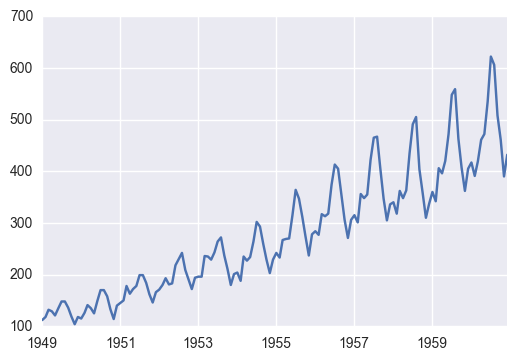

In [7]:
# Plot time series
plt.plot(ts.index, ts)

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


# Dickey-Fuller Test Results #
Test Statistic            0.815369
p-value                   0.991880
# Lags Used              13.000000
# Observations Used     130.000000
Critical Value (5%)      -2.884042
Critical Value (1%)      -3.481682
Critical Value (10%)     -2.578770
dtype: float64


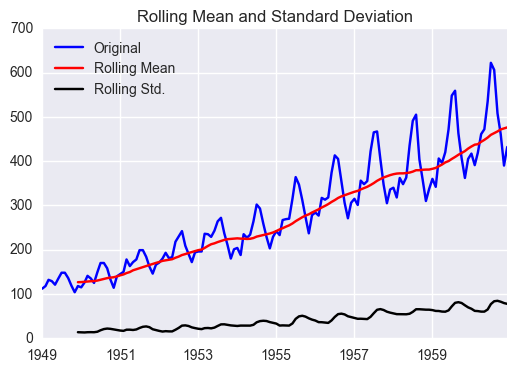

In [8]:
# Testing stationarity
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts):
    '''
    Test stationarity of a timeseries
    input: timeseries
    '''
    # Find: Rolling mean and std
    roll_mean = pd.rolling_mean(ts, window=12)
    roll_std = pd.rolling_std(ts, window=12)
    
    # Plot: Rolling mean and standard deviation
    original = plt.plot(ts.index, ts, color='blue', label='Original')
    mean = plt.plot(ts.index, roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(ts.index, roll_std, color='black', label='Rolling Std.')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # Perform Dickey-Fuller Test
    print '# Dickey-Fuller Test Results #'
    DF_test = adfuller(ts, autolag='AIC')
    DF_output = pd.Series(DF_test[0:4], index=['Test Statistic',
                                               'p-value',
                                               '# Lags Used',
                                               '# Observations Used'])
    
    for key, value in DF_test[4].items():
        DF_output['Critical Value ({})'.format(key)] = value
    print DF_output
    
test_stationarity(ts)

Above time series is not stationary
- Mean is increasing with time 

#### Estimating and eliminating trend

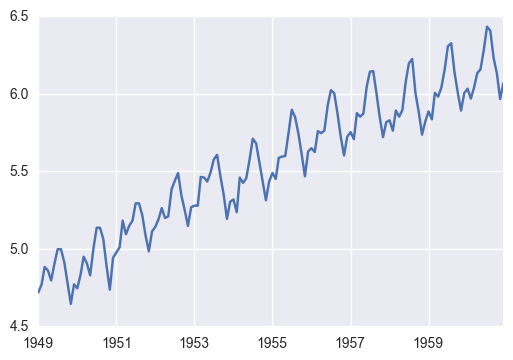

In [9]:
# Transformation
ts_log = np.log(ts)
plt.plot(ts_log.index, ts_log)

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  from ipykernel import kernelapp as app


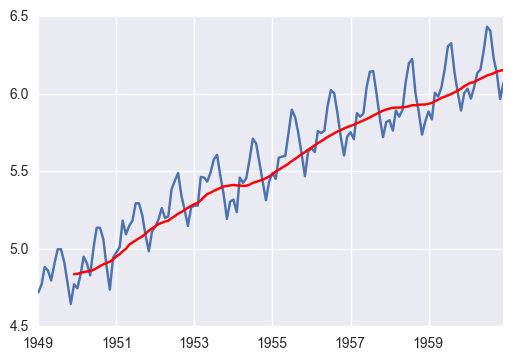

In [10]:
# Moving average
moving_avg = pd.rolling_mean(ts_log, 12)
plt.plot(ts_log.index, ts_log)
plt.plot(moving_avg.index, moving_avg, color='red')

In [11]:
# Difference
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #Passengers, dtype: float64

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


# Dickey-Fuller Test Results #
Test Statistic           -3.162908
p-value                   0.022235
# Lags Used              13.000000
# Observations Used     119.000000
Critical Value (5%)      -2.886151
Critical Value (1%)      -3.486535
Critical Value (10%)     -2.579896
dtype: float64


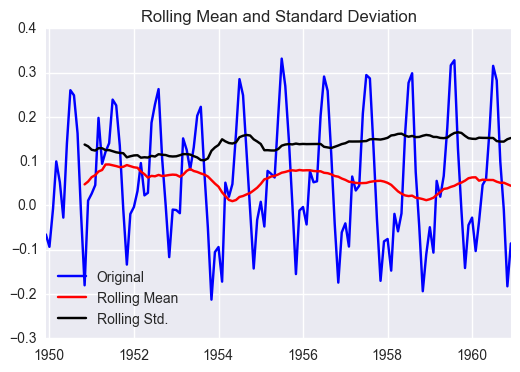

In [12]:
# Drop NaN's
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=12,ignore_na=False,min_periods=0,adjust=True).mean()
  app.launch_new_instance()


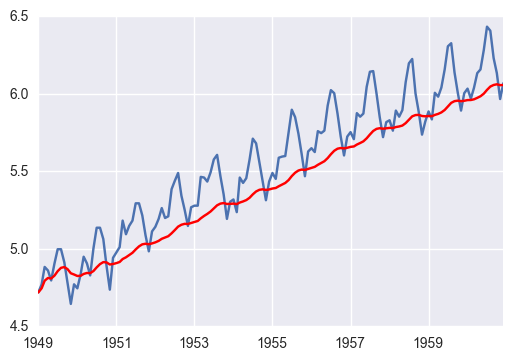

In [13]:
# Weighted moving average: Recent values given more weight
# Exponentially weighted moving average: Weight assigned to previous values with decay factor
exp_weighted_moving_avg = pd.ewma(ts_log, halflife=12)
plt.plot(ts_log.index, ts_log)
plt.plot(exp_weighted_moving_avg.index, exp_weighted_moving_avg, color='red')

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


# Dickey-Fuller Test Results #
Test Statistic           -3.601262
p-value                   0.005737
# Lags Used              13.000000
# Observations Used     130.000000
Critical Value (5%)      -2.884042
Critical Value (1%)      -3.481682
Critical Value (10%)     -2.578770
dtype: float64


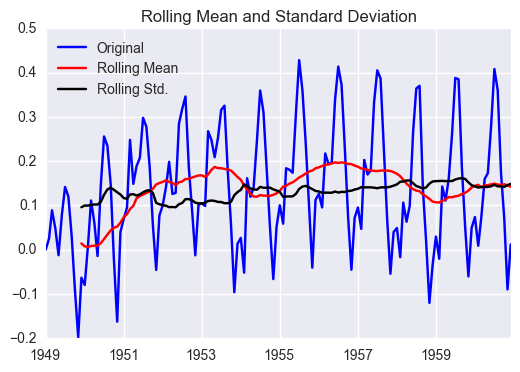

In [14]:
ts_log_ewma_diff = ts_log - exp_weighted_moving_avg
test_stationarity(ts_log_ewma_diff)

#### Estimating trend and Seasonality

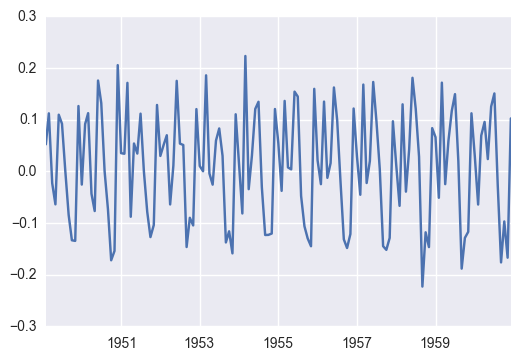

In [15]:
# Differencing
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff.index, ts_log_diff)

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


# Dickey-Fuller Test Results #
Test Statistic           -2.717131
p-value                   0.071121
# Lags Used              14.000000
# Observations Used     128.000000
Critical Value (5%)      -2.884398
Critical Value (1%)      -3.482501
Critical Value (10%)     -2.578960
dtype: float64


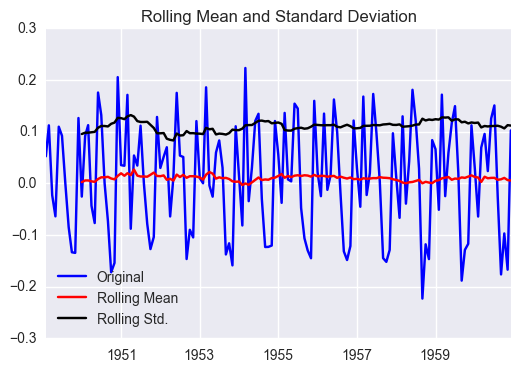

In [16]:
# Dron NaN
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

In [17]:
# Seasonality: statsmodel upgrade issue
#from statsmodels.tsa.seasonal import seasonal_decompose
#decomposed = seasonal_decompose(ts_log)

#### Forecasting a Time Series

In [18]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

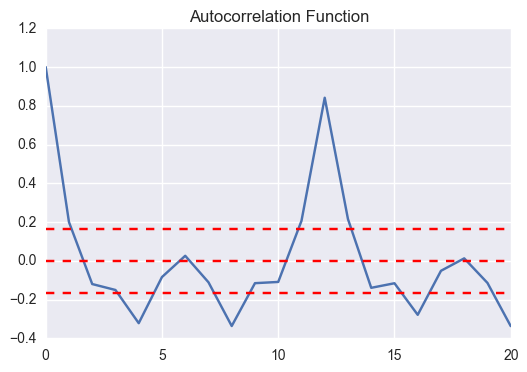

In [19]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

# Plot ACF
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='red')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='red')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='red')
plt.title('Autocorrelation Function')

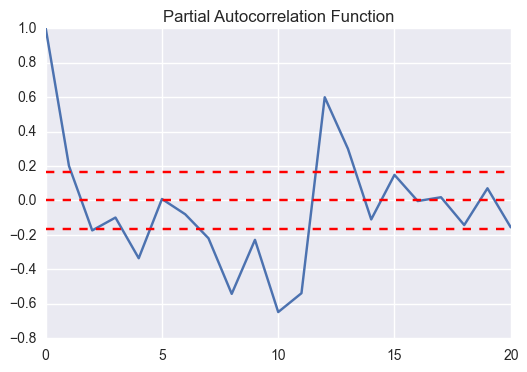

In [20]:
# Plot PACF
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='red')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='red')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='red')
plt.title('Partial Autocorrelation Function')